## Giriş - Modül yükleme

Bu projede, elmizde kullanıcıların elektrik kullanımıyla ilgili çeşitli bilgiler içeren verilerimiz vardır. Burada tahminlememiz istenen hedef değişken tüketimin kaçak olup olmadığı bilgisini içeren **NK_FLAG** sütunudur, bu sütunun değeri 1'se tüketim kaçak, 0'sa tüketim kaçak değil demektir. **15.000 satırlık bir veri setinden model eğiterek 5.000 satırlık bir test setini tahminlememiz** istenmektedir.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Verileri yükleme ve ilk bakış

In [2]:
# train seti : 

train_df = pd.read_excel("train_5.xlsx")

# test seti :

test_features = pd.read_excel("Test_Data.xlsx")
test_target = pd.read_excel("Test_Data_Actual.xlsx")

test_df = pd.concat([test_features, test_target], axis=1)
test_df = test_df.drop(["INDEX","NK_FLAG","ID"], axis=1)
test_df = test_df.rename(columns={'Actual (NK_FLAG)': 'NK_FLAG'})

In [3]:
#train veri setine ilk bakış

pd.set_option("display.max_columns", None)
train_df.head()

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,TUKETIM_M11,TUKETIM_M12,TUKETIM_M13,TUKETIM_M14,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12,SOB_RISK_SKORU,SOKAK_RISK_SKORU,MAHALLE_RISK_SKORU,TESISAT_TIPI,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,54.067286,260.483048,275.618048,273.467499,281.655063,352.713057,415.387382,506.970118,536.242000,497.518271,471.083198,315.163173,315.871357,274.376412,300.337088,273.352000,266.875034,309.120407,326.750892,354.539943,318.070421,330.373589,345.701621,327.902260,5.772,7.664,NaN,7.228,8.520,4.524,6.028,5.820,2.580,6.264,7.172,3.008,0.002008,0.000000,0.009129,Mesken,2016-10-18,9999-12-31 00:00:00,LUNA,LUN1,80000100.0,Aktif,Monofaze,2016-10-18,2012.0,0
1,125.413387,227.864889,253.651891,230.289027,241.382306,248.334700,217.821800,249.203886,246.356225,203.709124,204.614265,227.282016,252.688863,234.528121,290.624533,269.826633,215.697424,202.549150,230.007616,239.995010,226.454837,220.314917,218.741546,211.675245,5.196,7.884,8.396,6.692,5.972,6.832,3.304,3.772,3.808,3.124,3.276,7.988,0.014563,0.011905,0.006006,Mesken,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-25,2015.0,0
2,308.273107,386.164464,392.016065,238.200398,163.968966,162.782897,187.088937,212.920402,204.618086,181.509614,162.532761,180.364045,200.545258,177.086519,193.950044,211.346271,238.872425,257.272032,294.784710,283.357450,226.819491,230.758659,206.737582,194.363068,4.644,3.816,2.880,4.136,2.440,1.672,1.372,1.664,2.188,2.152,2.352,2.236,0.000000,0.000000,0.004923,Mesken,2016-10-11,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000730.0,Aktif,Trifaze,2016-10-11,2016.0,0
3,23.105143,49.197286,64.653696,73.807875,31.418710,31.834563,24.261624,27.079161,26.952110,32.072690,24.478705,42.151289,51.868976,55.239458,108.295683,89.818174,37.593545,27.744979,26.212989,21.814145,22.798067,18.199133,18.319485,24.635136,0.160,0.364,0.404,0.424,0.284,0.356,0.204,0.156,0.208,0.288,0.268,0.296,0.013100,0.007194,0.016481,Ticarethane-Sanayi,2016-05-24,9999-12-31 00:00:00,LUNA,LUN10,80000710.0,Aktif,Monofaze,2016-05-24,2016.0,0
4,36.016793,48.795995,50.209868,50.969201,49.746943,89.461700,328.368786,469.163521,432.848994,461.588897,606.119366,688.857188,728.733365,509.289004,532.276781,632.535600,646.499034,624.308966,575.821111,540.784103,594.512266,672.500911,46.106609,0.000000,4.168,4.156,3.180,4.180,2.740,3.124,4.108,2.900,4.288,3.508,4.424,7.324,0.002915,0.000000,0.003135,Mesken,2018-05-30,9999-12-31 00:00:00,LUNA,LUN10-B,80001000.0,Aktif,Monofaze,2018-05-30,2017.0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TUKETIM_M1              15000 non-null  float64       
 1   TUKETIM_M2              15000 non-null  float64       
 2   TUKETIM_M3              15000 non-null  float64       
 3   TUKETIM_M4              15000 non-null  float64       
 4   TUKETIM_M5              15000 non-null  float64       
 5   TUKETIM_M6              15000 non-null  float64       
 6   TUKETIM_M7              15000 non-null  float64       
 7   TUKETIM_M8              15000 non-null  float64       
 8   TUKETIM_M9              15000 non-null  float64       
 9   TUKETIM_M10             15000 non-null  float64       
 10  TUKETIM_M11             15000 non-null  float64       
 11  TUKETIM_M12             15000 non-null  float64       
 12  TUKETIM_M13             14956 non-null  float6

In [5]:
#test veri setine ilk bakış

test_df.head()

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,TUKETIM_M11,TUKETIM_M12,TUKETIM_M13,TUKETIM_M14,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12,SOB_RISK_SKORU,SOKAK_RISK_SKORU,MAHALLE_RISK_SKORU,TESISAT_TIPI,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,120.655929,408.421620,441.702935,369.728331,324.862299,268.734368,228.187282,274.817339,315.189666,325.868031,338.066781,349.263806,419.406470,397.500384,531.576533,442.973809,332.087064,312.090201,282.113030,281.303424,281.941628,294.525736,274.388817,287.307383,8.332,8.276,6.856,7.028,10.228,2.448,3.428,2.276,3.048,5.608,7.236,7.972,0.007634,0.000000,0.007143,Mesken,2016-10-06,9999-12-31 00:00:00,LUNA,LUN1,80000100.0,Aktif,Monofaze,2016-10-06,2010.0,0
1,5.130929,23.391071,56.158545,75.614418,83.396237,118.008646,160.092154,246.899889,265.490444,159.416667,146.046500,125.686500,125.905897,122.247555,156.193048,154.644031,132.361953,137.633304,171.848389,278.578789,312.774389,181.138100,151.862930,135.881473,0.096,0.508,0.516,1.216,1.532,1.932,2.104,2.444,2.268,2.316,2.600,2.652,0.008097,0.008130,0.011616,Mesken,2020-03-13,9999-12-31 00:00:00,LUNA,LUN10-B,80001000.0,Aktif,Monofaze,2020-03-13,2020.0,0
2,13.447862,128.010848,117.153258,105.509955,113.085477,140.960083,142.909760,171.249824,186.267902,150.892686,98.184942,141.105968,149.666935,192.471259,308.596724,285.095962,223.577956,286.768114,411.898861,498.706875,552.804917,490.393208,206.294425,190.277981,1.300,1.248,0.328,0.392,0.584,0.644,0.540,0.444,0.708,0.264,0.452,NaN,0.005714,0.000000,0.002616,Ticarethane-Sanayi,2016-09-21,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-21,2014.0,0
3,11.027586,62.247614,122.927679,176.014306,78.527215,50.795497,190.349716,166.422780,236.395179,252.871134,112.680559,104.863557,116.330679,61.243100,117.875400,123.038600,147.808275,194.462736,238.487951,236.370438,175.040276,147.324524,145.167481,193.056719,8.556,0.168,6.380,1.468,0.352,2.844,2.956,0.184,11.768,4.728,0.184,0.176,0.000000,0.005362,0.008957,Mesken,2016-09-27,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000730.0,Aktif,Trifaze,2016-09-27,2014.0,0
4,33.407857,92.741936,95.597571,114.905710,154.649526,195.838572,231.303161,261.736367,259.075685,236.816803,215.028812,177.465926,223.616874,292.000655,373.391903,364.808717,229.507732,179.752017,215.332376,246.195371,233.520118,212.271685,187.955728,132.378426,0.892,1.472,1.676,1.584,1.644,1.708,0.496,2.240,0.720,1.128,0.488,1.212,0.037234,0.000000,0.054377,Mesken,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-25,2015.0,0


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TUKETIM_M1              5000 non-null   float64       
 1   TUKETIM_M2              5000 non-null   float64       
 2   TUKETIM_M3              5000 non-null   float64       
 3   TUKETIM_M4              5000 non-null   float64       
 4   TUKETIM_M5              5000 non-null   float64       
 5   TUKETIM_M6              5000 non-null   float64       
 6   TUKETIM_M7              5000 non-null   float64       
 7   TUKETIM_M8              5000 non-null   float64       
 8   TUKETIM_M9              5000 non-null   float64       
 9   TUKETIM_M10             5000 non-null   float64       
 10  TUKETIM_M11             5000 non-null   float64       
 11  TUKETIM_M12             5000 non-null   float64       
 12  TUKETIM_M13             4989 non-null   float64 

## Preprocessing

In [7]:
# preprocessing işleminin fonksiyonelleştirilmiş hali

def preprocessing(df):
    
    # SAYAC_MALZEME_ID string tipine dönüştürülmüştür:
    # Çünkü buradaki değerler sayısal olarak bir anlam ifade etmeyip sözel bir malzemeyi temsil etmektedir
    df["SAYAC_MALZEME_ID"] = df["SAYAC_MALZEME_ID"].astype(str)
    
    # SAYAC_YAPIM_YILI değişkeni için NaN değerlerin median ile doldurulması: 
    df["SAYAC_YAPIM_YILI"] = df["SAYAC_YAPIM_YILI"].fillna(df["SAYAC_YAPIM_YILI"].median())
    
    # Kategorik değişkenlerinde bulunan NaN değerler "MISSING" ile doldurulmuştur:
    df["SAYAC_MALZEME_ID"].fillna("MISSING", inplace=True)
    df["SAYAC_OLCUM_TURU"].fillna("MISSING", inplace=True)
    df["SAYAC_FAZ_N"].fillna("MISSING", inplace=True)
    
    # SAYAC_YAPIM_YILI ve SAYAC_BASLANGIC_TARIHI tarihi kullanılarak "sayac_yas" adlı bir feature oluşturulmuştur:
    # Çünkü sayaçın yapıldığı yıldan ziyade takıldığı dönemde kaç yıllık olduğu bilgisinin daha önemli olduğu düşünülmüştür
    df['year'] = pd.DatetimeIndex(df['SAYAC_BASLANGIC_TARIHI']).year
    df["year"] = df["year"].fillna(df["year"].median())
    df["sayac_yas"] = df['year'] - df["SAYAC_YAPIM_YILI"]

    # TUKETIM ve DEMAND değişkenleri için NaN değerler ortalamayla doldurulmuştur:
    col_base = ("TUKETIM", "DEMAND")
    for col in df.columns:
        if col.startswith(col_base):
            df[col].fillna(df[col].mean(), inplace=True)
            
    # Aylık tüketimlerin bir önceki aya göre yüzdesel değişimi bulunup "YUZDE_X" adlı feature'lar oluşturulmuştur
    # Çünkü kaçak tespitinde ani artış ve düşüşler önemlidir 
    for i in range(1,24):
        df[f"YUZDE_{i}"] = (abs(df[f"TUKETIM_M{i+1}"]-df[f"TUKETIM_M{i}"]) / df[f"TUKETIM_M{i}"])*100
    
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
        
    # İşlem yapılmayacak kolonların veri seti içerisinden çıkartılması:
    # Tarih kolonları gerekli bilgiler alındıktan sonra çıkarıldı
    # SAYAC_MARKA ve SAYAC_MODEL kolonları SAYAC_MALZEME_ID'nin bunları temsil ettiği düşünüldüğü için çıkarıldı
    # year kolonu sayac_yas üretebilmek için geçici olarak oluşturulmuştu
    # SAYAC_YAPIM_YILI, sayac_yas kolonu üretildikten sonra silindi
    df = df.drop(['year', "SAYAC_BASLANGIC_TARIHI", "SAYAC_YAPIM_YILI", "SAYAC_MARKA", "SAYAC_MODEL", 
                  "SAYAC_TAKILMA_TARIHI", "SAYAC_BITIS_TARIHI"], axis = 1)
    return df

In [8]:
# Oluşturulan fonksiyon çağrılarak test ve train dataframe'leri için ayrı ayrı preprocessing işlemlerini gerçekleştirir:

train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [9]:
# preprocessing işlemi sonrası train veri seti

train_df.head()

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,TUKETIM_M11,TUKETIM_M12,TUKETIM_M13,TUKETIM_M14,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12,SOB_RISK_SKORU,SOKAK_RISK_SKORU,MAHALLE_RISK_SKORU,TESISAT_TIPI,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,NK_FLAG,sayac_yas,YUZDE_1,YUZDE_2,YUZDE_3,YUZDE_4,YUZDE_5,YUZDE_6,YUZDE_7,YUZDE_8,YUZDE_9,YUZDE_10,YUZDE_11,YUZDE_12,YUZDE_13,YUZDE_14,YUZDE_15,YUZDE_16,YUZDE_17,YUZDE_18,YUZDE_19,YUZDE_20,YUZDE_21,YUZDE_22,YUZDE_23
0,54.067286,260.483048,275.618048,273.467499,281.655063,352.713057,415.387382,506.970118,536.242000,497.518271,471.083198,315.163173,315.871357,274.376412,300.337088,273.352000,266.875034,309.120407,326.750892,354.539943,318.070421,330.373589,345.701621,327.902260,5.772,7.664,3.2898,7.228,8.520,4.524,6.028,5.820,2.580,6.264,7.172,3.008,0.002008,0.000000,0.009129,Mesken,80000100.0,Aktif,Monofaze,0,4.0,381.775706,5.810359,0.780264,2.993981,25.228730,17.769210,22.047549,5.773887,7.221316,5.313387,33.098193,0.224704,13.136660,9.461701,8.984934,2.369460,15.829646,5.703436,8.504659,10.286435,3.868064,4.639606,5.148764
1,125.413387,227.864889,253.651891,230.289027,241.382306,248.334700,217.821800,249.203886,246.356225,203.709124,204.614265,227.282016,252.688863,234.528121,290.624533,269.826633,215.697424,202.549150,230.007616,239.995010,226.454837,220.314917,218.741546,211.675245,5.196,7.884,8.3960,6.692,5.972,6.832,3.304,3.772,3.808,3.124,3.276,7.988,0.014563,0.011905,0.006006,Mesken,80000730.0,Aktif,Monofaze,0,1.0,81.691041,11.316795,9.210601,4.817112,2.880242,12.287006,14.407229,1.142703,17.311152,0.444330,11.078285,11.178556,7.186998,23.918843,7.156278,20.060736,6.095703,13.556446,4.342201,5.641856,2.711322,0.714146,3.230434
2,308.273107,386.164464,392.016065,238.200398,163.968966,162.782897,187.088937,212.920402,204.618086,181.509614,162.532761,180.364045,200.545258,177.086519,193.950044,211.346271,238.872425,257.272032,294.784710,283.357450,226.819491,230.758659,206.737582,194.363068,4.644,3.816,2.8800,4.136,2.440,1.672,1.372,1.664,2.188,2.152,2.352,2.236,0.000000,0.000000,0.004923,Mesken,80000730.0,Aktif,Trifaze,0,0.0,25.266997,1.515313,39.237083,31.163438,0.723350,14.931569,13.807051,3.899258,11.293465,10.455012,10.970886,11.189155,11.697479,9.522761,8.969437,13.024197,7.702692,14.580939,3.876476,19.952875,1.736697,10.409610,5.985614
3,23.105143,49.197286,64.653696,73.807875,31.418710,31.834563,24.261624,27.079161,26.952110,32.072690,24.478705,42.151289,51.868976,55.239458,108.295683,89.818174,37.593545,27.744979,26.212989,21.814145,22.798067,18.199133,18.319485,24.635136,0.160,0.364,0.4040,0.424,0.284,0.356,0.204,0.156,0.208,0.288,0.268,0.296,0.013100,0.007194,0.016481,Ticarethane-Sanayi,80000710.0,Aktif,Monofaze,0,0.0,112.927858,31.417202,14.158786,57.431765,1.323585,23.788419,11.613142,0.469184,18.998813,23.677418,72.195746,23.054304,6.498070,96.047693,17.062092,58.144835,26.197491,5.521686,16.781161,4.510476,20.172471,0.661304,34.475047
4,36.016793,48.795995,50.209868,50.969201,49.746943,89.461700,328.368786,469.163521,432.848994,461.588897,606.119366,688.857188,728.733365,509.289004,532.276781,632.535600,646.499034,624.308966,575.821111,540.784103,594.512266,672.500911,46.106609,0.000000,4.168,4.156,3.1800,4.180,2.740,3.124,4.108,2.900,4.288,3.508,4.424,7.324,0.002915,0.000000,0.003135,Mesken,80001000.0,Aktif,Monofaze,0,1.0,35.481231,2.897520,1.512317,2.398033,79.833563,267.049571,42.877015,7.740271,6.639707,31.311513,13.650417,5.788744,30.113121,4.513700,18.835843,2.207533,3.432344,7.766644,6.084704,9.935233,13.118089,93.144008,100.000000


## Encoding & Scaling

In [10]:
# encode edilecek kolonların seçilmesi

columns_to_encode = []

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        columns_to_encode.append(col)
print(columns_to_encode)

['TESISAT_TIPI', 'SAYAC_MALZEME_ID', 'SAYAC_OLCUM_TURU', 'SAYAC_FAZ_N']


In [11]:
# scale edilecek kolonların seçilmesi

columns_to_scale = ['TUKETIM_M1', 'TUKETIM_M2', 'TUKETIM_M3', 'TUKETIM_M4', 'TUKETIM_M5',
                        'TUKETIM_M6', 'TUKETIM_M7', 'TUKETIM_M8', 'TUKETIM_M9', 'TUKETIM_M10',
                        'TUKETIM_M11', 'TUKETIM_M12', 'TUKETIM_M13', 'TUKETIM_M14',
                        'TUKETIM_M15', 'TUKETIM_M16', 'TUKETIM_M17', 'TUKETIM_M18',
                        'TUKETIM_M19', 'TUKETIM_M20', 'TUKETIM_M21', 'TUKETIM_M22',
                        'TUKETIM_M23', 'TUKETIM_M24', 'DEMAND_M1', 'DEMAND_M2', 'DEMAND_M3',
                        'DEMAND_M4', 'DEMAND_M5', 'DEMAND_M6', 'DEMAND_M7', 'DEMAND_M8',
                        'DEMAND_M9', 'DEMAND_M10', 'DEMAND_M11', 'DEMAND_M12', 'SOB_RISK_SKORU',
                        'SOKAK_RISK_SKORU', "MAHALLE_RISK_SKORU", "sayac_yas", 'YUZDE_1',
                    'YUZDE_2','YUZDE_3','YUZDE_4','YUZDE_5','YUZDE_6','YUZDE_7','YUZDE_8','YUZDE_9',
                    'YUZDE_10','YUZDE_11','YUZDE_12','YUZDE_13','YUZDE_14','YUZDE_15','YUZDE_16','YUZDE_17',
                    'YUZDE_18','YUZDE_19','YUZDE_20','YUZDE_21','YUZDE_22','YUZDE_23']

In [12]:
# encode ve scale işlemleri:
# RobustScaler outlier değerler içeren veri setlerinde daha iyi sonuçlar verdiği için kullanıldı
# OneHotEncoder kategorik değişkenlerimiz ordinal değil nominal olduğu için kullanıldı 

rs = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', dtype="int64")

ct = make_column_transformer((ohe, columns_to_encode), remainder="passthrough")
train_df = pd.DataFrame(ct.fit_transform(train_df), columns=ct.get_feature_names())
test_df = pd.DataFrame(ct.transform(test_df),columns=ct.get_feature_names())

train_df[columns_to_scale] = rs.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = rs.fit_transform(test_df[columns_to_scale])

In [13]:
#encode ve scale işlemleri sonrası train veri seti

train_df.head()

,onehotencoder__x0_Mesken,onehotencoder__x0_Ticarethane-Sanayi,onehotencoder__x1_80000000.0,onehotencoder__x1_80000010.0,onehotencoder__x1_80000020.0,onehotencoder__x1_80000030.0,onehotencoder__x1_80000060.0,onehotencoder__x1_80000070.0,onehotencoder__x1_80000080.0,onehotencoder__x1_80000100.0,onehotencoder__x1_80000110.0,onehotencoder__x1_80000120.0,onehotencoder__x1_80000150.0,onehotencoder__x1_80000160.0,onehotencoder__x1_80000520.0,onehotencoder__x1_80000620.0,onehotencoder__x1_80000710.0,onehotencoder__x1_80000720.0,onehotencoder__x1_80000730.0,onehotencoder__x1_80000740.0,onehotencoder__x1_80000750.0,onehotencoder__x1_80000760.0,onehotencoder__x1_80000770.0,onehotencoder__x1_80000790.0,onehotencoder__x1_80000800.0,onehotencoder__x1_80000850.0,onehotencoder__x1_80000860.0,onehotencoder__x1_80000950.0,onehotencoder__x1_80000960.0,onehotencoder__x1_80000970.0,onehotencoder__x1_80000980.0,onehotencoder__x1_80000990.0,onehotencoder__x1_80001000.0,onehotencoder__x1_80001010.0,onehotencoder__x1_80001020.0,onehotencoder__x1_80001030.0,onehotencoder__x1_nan,onehotencoder__x2_Aktif,onehotencoder__x2_Kombi,onehotencoder__x2_MISSING,onehotencoder__x3_MISSING,onehotencoder__x3_Monofaze,onehotencoder__x3_Trifaze,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,TUKETIM_M11,TUKETIM_M12,TUKETIM_M13,TUKETIM_M14,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12,SOB_RISK_SKORU,SOKAK_RISK_SKORU,MAHALLE_RISK_SKORU,NK_FLAG,sayac_yas,YUZDE_1,YUZDE_2,YUZDE_3,YUZDE_4,YUZDE_5,YUZDE_6,YUZDE_7,YUZDE_8,YUZDE_9,YUZDE_10,YUZDE_11,YUZDE_12,YUZDE_13,YUZDE_14,YUZDE_15,YUZDE_16,YUZDE_17,YUZDE_18,YUZDE_19,YUZDE_20,YUZDE_21,YUZDE_22,YUZDE_23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.038572,0.636969,0.609285,0.668878,1.084032,1.656216,1.656216,1.646543,2.065360,2.346094,2.334356,1.243797,1.018012,0.805132,0.744949,0.674740,0.922008,1.298304,1.103755,0.947241,0.886056,1.326756,1.622158,1.700294,1.214552,1.867634,0.106870,1.948490,3.290393,1.722151,2.237319,2.153938,0.170404,2.847626,2.825283,-0.105637,-0.299459,0.000000,0.221831,0.0,1.000000,1.130229,-0.285729,-0.447880,-0.449713,0.660129,0.075102,0.192676,-0.218362,-0.243722,-0.305744,0.861523,-0.472561,0.039954,-0.233505,-0.016829,-0.454255,0.132369,-0.268468,-0.237229,0.036855,-0.398991,-0.290606,-0.320831
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.667118,0.452427,0.496549,0.429160,0.782379,0.849061,0.417961,0.396677,0.486863,0.390974,0.451686,0.630455,0.635784,0.564433,0.694020,0.654608,0.544547,0.466572,0.484315,0.360036,0.366708,0.526356,0.613820,0.688677,0.999627,1.963957,1.915014,1.692856,1.899563,3.512686,0.592391,0.851139,0.858744,0.417286,0.502087,1.602390,0.728439,1.151361,-0.062369,0.0,0.000000,-0.115300,-0.005310,-0.030443,-0.389180,-0.402651,-0.080834,-0.050819,-0.454464,0.163159,-0.517530,-0.091131,-0.077122,-0.270629,0.360717,-0.112694,0.153490,-0.280107,-0.035128,-0.378600,-0.200481,-0.440313,-0.464578,-0.431245
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.475801,1.348032,1.206671,0.473082,0.202533,0.187492,0.225341,0.220745,0.259588,0.243249,0.154369,0.303005,0.320338,0.217463,0.187094,0.320653,0.715474,0.893655,0.899078,0.582330,0.368775,0.602308,0.518483,0.537996,0.793657,0.182871,-0.038244,0.473827,-0.028384,-0.490417,-0.574275,-0.489828,-0.049327,-0.335036,-0.048897,-0.370415,-0.463859,0.000000,-0.160929,0.0,-0.333333,-0.349493,-0.504458,1.456353

## Oversampling - Feature and Target

Veri setimiz **imbalance** (dengesiz) olduğu için bu haliyle modelimiz veri setindeki oranı çok az olan NK_FLAG sütunundaki (yani hedef sütundaki) 1'leri yeterince iyi tanıyamaz. O yüzden tüm veri setinde %6.8 olan 1 oranını arttırmamız, yani **oversampling** yapmamız gerekmektedir.

In [14]:
# train_df'in target ve diğer değişkenlerinin ayrılması: 

X = train_df.loc[:, train_df.columns != 'NK_FLAG']
y = train_df["NK_FLAG"]

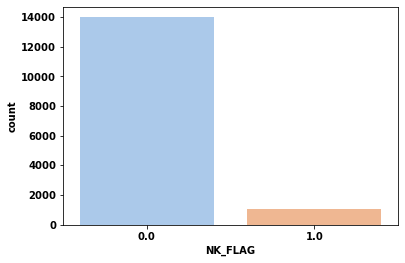

In [15]:
# oversampling öncesi target değişkenin dağılımı

chck = pd.DataFrame()
chck['NK_FLAG'] = y

sns.countplot(chck['NK_FLAG'],palette="pastel");

In [16]:
# train için ayrılan train_df'i kendi içinde train ve test olarak böldükten sonra, oversampling uygulaması: 
# oversampling yapıldı ve 1'ler 0'ların yarısı oranına getirildi
# daha az sentetik veri üretmek daha iyi sonuç verdiği için bu oranda oversampling yapıldı

oversample = SMOTE(sampling_strategy=0.5,random_state=9)
X_over, y_over = oversample.fit_resample(X, y)

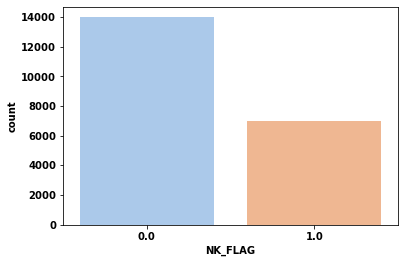

In [17]:
# oversampling sonrası target değişkenin dağılımı

chck2 = pd.DataFrame()
chck2['NK_FLAG'] = y_over

sns.countplot(chck2['NK_FLAG'],palette="pastel");

## Model ve Tahmin
### Train Seti ile CatBoost modelinin eğitilmesi ve test verileriyle karşılaştırılması:

CatBoost öncesi **XGBoost**, **Random Forest**, **SVM** gibi modeller de denenmiştir ancak en iyi sonuçlar CatBoost'tan elde edilmiştir

In [18]:
# test setinden hedef değişken ile diğer değişkenlerin ayrıştırılması: 

X_test = test_df.loc[:, test_df.columns != 'NK_FLAG']
y_actual = test_df["NK_FLAG"]

In [19]:
# catboost modelinin oluşturulması: 

cbc = CatBoostClassifier(silent=True, random_state=111)

cbc.fit(X_over, y_over)

96.94
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4687
         1.0       0.83      0.65      0.73       313

    accuracy                           0.97      5000
   macro avg       0.90      0.82      0.85      5000
weighted avg       0.97      0.97      0.97      5000



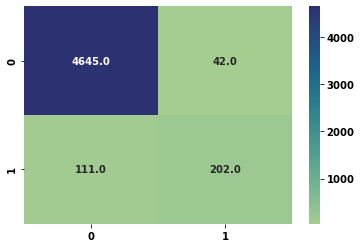

In [20]:
# modelin test seti üzerinde tahminlemesi

preds = cbc.predict(X_test)

score = cbc.score(X_test, y_actual)
print(score*100)
print(classification_report(y_actual, preds))

cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f', cmap="crest");

Aşağıda bu modelin **threshold** değerleriyle oynanarak oluşturulan 2 farklı model sunulmuştur. Bir tanesi **f1-score'ların maksimize** edildiği, diğeri **recall değerlerinin optimize** edildiği modellerdir. İkisinin de birbirine göre avantaj - dezavantajları vardır, iş modelinde nelerin önceliklendirildiğine bağlı olarak ikisi de seçilebilir.

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4687
         1.0       0.72      0.76      0.74       313

    accuracy                           0.97      5000
   macro avg       0.85      0.87      0.86      5000
weighted avg       0.97      0.97      0.97      5000



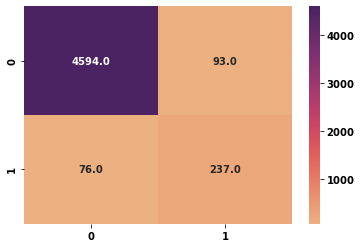

In [21]:
# thresholdun düşürülerek f1 skorunun maksimize edilmiş hali

preds = (cbc.predict_proba(X_test)[:,1] >= 0.29).astype(bool)

print(classification_report(y_actual, preds))
cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f',cmap="flare");

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      4687
         1.0       0.50      0.89      0.64       313

    accuracy                           0.94      5000
   macro avg       0.74      0.92      0.80      5000
weighted avg       0.96      0.94      0.94      5000



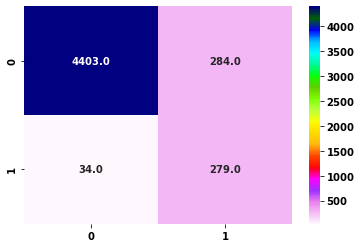

In [22]:
# thresholdun düşürülerek recall skorunun optimize edilmiş hali

preds = (cbc.predict_proba(X_test)[:,1] >= 0.08).astype(bool)

print(classification_report(y_actual, preds))
cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f',cmap="gist_ncar_r");